<a href="https://www.kaggle.com/code/roohankhan/house-price-predictor?scriptVersionId=193001328" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# PRICE PREDICTOR FOR HOUSES IN INDIA

**SETUP**

In [1]:
# IMPORT LIBRARIES AND FUNCTIONS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeRegressor

**CUSTOM FUNCTIONS**

In [2]:
# To convert 'Amount' to int
def convert_amount(amount_str):
    amount_str = amount_str.strip().lower()
    if 'lac' in amount_str:
        value = float(amount_str.replace('lac', '').strip())
        return value * 100000
    elif 'cr' in amount_str:
        value = float(amount_str.replace('cr', '').strip())
        return value * 10000000
    elif 'call' in amount_str:
        return 0

# To covert 'Area' to int
def convert_area(amount_str):
    amount_str = str(amount_str)
    amount_str = amount_str.strip().lower()
    if ',' in amount_str: 
        amount_str = amount_str.replace(',', '').strip()
    if 'sqft' in amount_str:
        value = float(amount_str.replace('sqft', '').strip())
        return value

# To add new feature "Floor Ratio"
def floor_ratio(floor_str):
    floor_str = str(floor_str)
    floor = floor_str.split()[0]
    total_floors = floor_str.split()[-1]    
    if floor in ['Ground', 'Upper', 'Lower','Unknown']: return 0
    return int(floor)/int(total_floors)

# For ordinal encoding
def ordinal_encoding(data,col, order):
    data[col]=data[col].fillna('Unknown')
    ordinal_encoder = OrdinalEncoder(categories=order)
    data[col] = ordinal_encoder.fit_transform(data[[col]])
    return data[col]

# For label encoding
def label_encoding(data,col):
    data[col]=data[col].fillna('Unknown')
    label_encoder = LabelEncoder()
    data[col] = label_encoder.fit_transform(data[[col]])
    return data[col]

# To convert str to int
def consistent_data(quantity_str):
    quantity_str = str(quantity_str)
    if quantity_str.strip()[0] == '>': return int(quantity_str.strip()[2]) + 2
    else: return int(quantity_str)
    
# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# Function to find mutual information scores
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# To plot graph of mi scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [3]:
# Load DF
house_full = pd.read_csv('/kaggle/input/house-price/house_prices.csv', index_col='Index')
# Format Amount column
house_full['Amount(in rupees)'] = house_full['Amount(in rupees)'].apply(convert_amount)
house_full

,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,Furnishing,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
Index,,,,,,,,,,,,,,,,,,,,
0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",4200000.0,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,Unfurnished,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,9800000.0,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,Semi-Furnished,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN
2,2 BHK Ready to Occupy Flat for sale in Sunrise...,Up for immediate sale is a 2 BHK apartment in ...,14000000.0,17500.0,thane,779 sqft,Ready to Move,10 out of 29,Resale,Unfurnished,East,Garden/Park,Sunrise by Kalpataru,2,NaN,1 Covered,Freehold,NaN,NaN,NaN
3,1 BHK Ready to Occupy Flat for sale Kasheli,This beautiful 1 BHK Flat is available for sal...,2500000.0,NaN,thane,530 sqft,Ready to Move,1 out of 3,Resale,Unfurnished,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN
4,2 BHK Ready to Occupy Flat for sale in TenX Ha...,"This lovely 2 BHK Flat in Pokhran Road, Thane ...",16000000.0,18824.0,thane,635 sqft,Ready to Move,20 out of 42,Resale,Unfurnished,West,"Garden/Park, Main Road",TenX Habitat Raymond Realty,2,NaN,1 Covered,Co-operative Society,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187526,3 BHK Ready to Occupy Flat for sale in Bollywo...,This magnificent 3 BHK Flat is available for s...,6300000.0,3225.0,zirakpur,NaN,Ready to Move,2 out of 4,New Property,Semi-Furnished,East,Garden/Park,Bollywood Esencia,3,3,1 Covered,Freehold,1953 sqft,NaN,NaN
187527,3 BHK Ready to Occupy Flat for sale in Sushma ...,Have a look at this immaculate 3 BHK flat for ...,5500000.0,3274.0,zirakpur,NaN,Ready to Move,4 out of 6,Resale,Unfurnished,North - East,"Garden/Park, Main Road",Sushma Urban Views,3,NaN,1 Covered,NaN,1680 sqft,NaN,NaN
187528,3 BHK Ready to Occupy Flat for sale in Bollywo...,"Gazipur, Zirakpur has an appealing 3 BHK flat ...",7600000.0,4343.0,zirakpur,1250 sqft,Ready to Move,1 out of 3,Resale,Furnished,East,"Garden/Park, Main Road",Bollywood Esencia,3,2,"1 Covered,",Freehold,NaN,NaN,NaN


**DATA VISUALIZATION**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

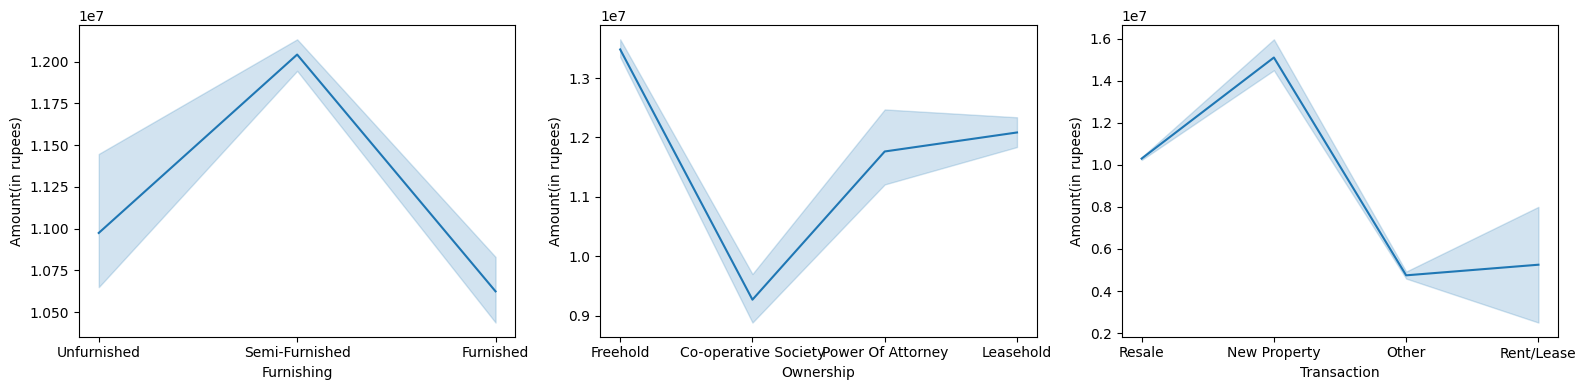

In [4]:
# Creating a 1(row)x3(column) grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot each graph on its respective subplot
sns.lineplot(data=house_full, x='Furnishing', y='Amount(in rupees)', ax=axes[0])
sns.lineplot(data=house_full, x='Ownership', y='Amount(in rupees)', ax=axes[1])
sns.lineplot(data=house_full, x='Transaction', y='Amount(in rupees)', ax=axes[2])

# Adjusting layout
plt.tight_layout()
plt.show()

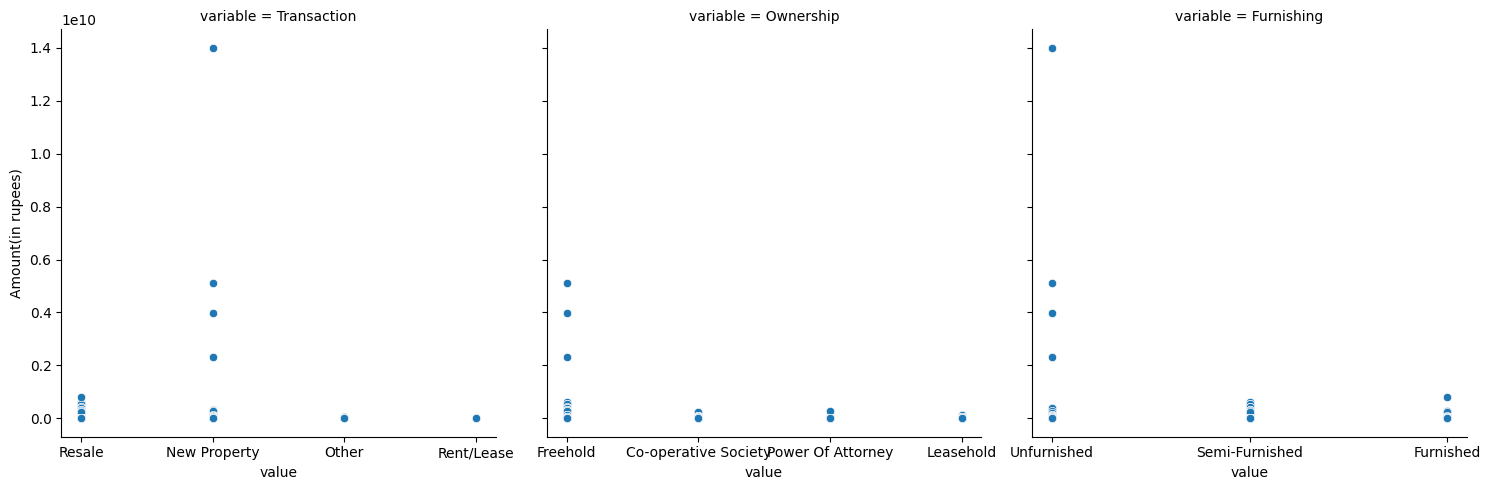

In [5]:
features = ["Transaction", "Ownership","Furnishing"]
sns.relplot(
    x="value", y="Amount(in rupees)", col="variable", data=house_full.melt(id_vars="Amount(in rupees)", value_vars=features), facet_kws=dict(sharex=False),
);

**DATA PREPROCESSING**

In [6]:
house_data = house_full.copy()

# Target
y = house_data.pop('Amount(in rupees)')

# Filling missing values
house_data['Bathroom'] = house_data['Bathroom'].fillna(1)
house_data['Balcony'] = house_data['Balcony'].fillna(1)

house_data['Bathroom']=house_data['Bathroom'].apply(consistent_data)
house_data['Balcony']=house_data['Balcony'].apply(consistent_data)

# Creating new feature for model
house_data['Floor'] = house_data['Floor'].fillna('Unknown')
house_data['Floor Ratio'] = house_data['Floor'].apply(floor_ratio)

# Changing Areas to int
house_data['Carpet Area']=house_data['Carpet Area'].fillna('Unknown')
house_data['Carpet Area'] = house_data['Carpet Area'].apply(convert_area)
house_data['Super Area']=house_data['Super Area'].fillna('Unknown')
house_data['Super Area'] = house_data['Super Area'].apply(convert_area)

# Combining Carpet and Super Area
house_data['Area'] = house_data['Carpet Area'].combine_first(house_data['Super Area'])

# Dropping extra columns with missing or useless data
house_data=house_data.drop(['Title','Description','Carpet Area','Super Area','Floor','Price (in rupees)','Status','Dimensions','Plot Area'], axis=1)

# Train and test data
X_train, X_test, y_train, y_test = train_test_split(house_data, y, train_size=0.8, test_size=0.2, random_state=0)

**CREATING PIPELINE**

In [7]:
numerical_cols = [cname for cname in house_data.columns if 
                house_data[cname].dtype in ['int64', 'float64']]
# Columns to be label encoded
label_encode_cols = ['facing', 'location']
# Columns to be ordinal encoded
ordinal_encode_cols = ['Transaction', 'Ownership', 'Furnishing']

# Custom transformer for label encoding
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}

    def fit(self, X, y=None):
        # Check if X is a DataFrame
        if isinstance(X, pd.DataFrame):
            columns = X.columns
        else:
            # If X is a numpy array, create column indices
            columns = range(X.shape[1])
        for idx, col in enumerate(columns):
            le = LabelEncoder()
            le.fit(X[:, idx] if isinstance(X, np.ndarray) else X[col])
            self.label_encoders[col] = le
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Check if X is a DataFrame
        if isinstance(X, pd.DataFrame):
            columns = X.columns
        else:
            # If X is a numpy array, create column indices
            columns = range(X.shape[1])
        for idx, col in enumerate(columns):
            le = self.label_encoders[col]
            X_copy[:, idx] = le.transform(X[:, idx]) if isinstance(X, np.ndarray) else le.transform(X_copy[col])
        return X_copy
# Orders for columns to be ordinally encoded
ordinal_categories = [
    ['Unknown', 'Other', 'Rent/Lease','Resale','New Property'],
    ['Unknown', 'Leasehold', 'Power Of Attorney','Co-operative Society','Freehold'],
    ['Unknown', 'Unfurnished', 'Semi-Furnished', 'Furnished']
]

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for label encoded categorical data
label_encoder_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label_encoder', CustomLabelEncoder())
])

# Preprocessing for ordinal encoded categorical data
ordinal_encoder_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(categories=ordinal_categories))
])

# Bundle preprocessing for numerical, label encoded, and ordinal encoded data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('label', label_encoder_transformer, label_encode_cols),
        ('ordinal', ordinal_encoder_transformer, ordinal_encode_cols)
    ])

model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fitting model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, getting predictions
preds = clf.predict(X_test)

print('MAE (Using Pipeline):', mean_absolute_error(y_test, preds))

MAE (Using Pipeline): 1379078.9141452098


**MANUAL ENCODING**

In [8]:
# FEATURES TO BE ENCODED
print(house_full['facing'].unique())
print()
print(house_full['location'].unique())
print()
print(house_full['Transaction'].unique())
print()
print(house_full['Ownership'].unique())
print()
print(house_full['Furnishing'].unique())

[nan 'East' 'West' 'North - East' 'North' 'North - West' 'South'
 'South -West' 'South - East']

['thane' 'navi-mumbai' 'nagpur' 'mumbai' 'ahmedabad' 'bangalore' 'chennai'
 'gurgaon' 'hyderabad' 'indore' 'jaipur' 'kolkata' 'lucknow' 'new-delhi'
 'noida' 'pune' 'agra' 'ahmadnagar' 'allahabad' 'aurangabad' 'badlapur'
 'belgaum' 'bhiwadi' 'bhiwandi' 'bhopal' 'bhubaneswar' 'chandigarh'
 'coimbatore' 'dehradun' 'durgapur' 'ernakulam' 'faridabad' 'ghaziabad'
 'goa' 'greater-noida' 'guntur' 'guwahati' 'gwalior' 'haridwar' 'jabalpur'
 'jamshedpur' 'jodhpur' 'kalyan' 'kanpur' 'kochi' 'kozhikode' 'ludhiana'
 'madurai' 'mangalore' 'mohali' 'mysore' 'nashik' 'navsari' 'nellore'
 'palakkad' 'palghar' 'panchkula' 'patna' 'pondicherry' 'raipur'
 'rajahmundry' 'ranchi' 'satara' 'shimla' 'siliguri' 'solapur' 'sonipat'
 'surat' 'thrissur' 'tirupati' 'trichy' 'trivandrum' 'udaipur' 'udupi'
 'vadodara' 'vapi' 'varanasi' 'vijayawada' 'visakhapatnam' 'vrindavan'
 'zirakpur']

['Resale' 'New Property' nan 'O

In [9]:
house_changed=house_data.copy()
house_changed['Amount(in rupees)'] = y

# Label Encoding
house_changed['facing']=label_encoding(house_changed,'facing')
house_changed['location']=label_encoding(house_changed,'location')

# Ordinal Encoding
house_changed['Transaction']=ordinal_encoding(house_changed,'Transaction',[['Unknown', 'Other', 'Rent/Lease','Resale','New Property']])
house_changed['Ownership']=ordinal_encoding(house_changed,'Ownership',[['Unknown', 'Leasehold', 'Power Of Attorney','Co-operative Society','Freehold']])
house_changed['Furnishing']=ordinal_encoding(house_changed,'Furnishing',[['Unknown', 'Unfurnished', 'Semi-Furnished', 'Furnished']])

# Fill in missing values
imputer = SimpleImputer(strategy='mean')
house_changed['Area'] = imputer.fit_transform(house_changed[['Area']])

useful_features = ['Amount(in rupees)','location','Transaction','Furnishing','facing','Bathroom','Balcony','Ownership','Floor Ratio','Area']

house_changed.head()

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,location,Transaction,Furnishing,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Floor Ratio,Area,Amount(in rupees)
Index,,,,,,,,,,,,,
0,67,3.0,1.0,7,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,0.0,0.909091,500.0,4200000.0
1,67,3.0,2.0,0,Garden/Park,Dosti Vihar,2,1,1 Open,4.0,0.136364,473.0,9800000.0
2,67,3.0,1.0,0,Garden/Park,Sunrise by Kalpataru,2,1,1 Covered,4.0,0.344828,779.0,14000000.0
3,67,3.0,1.0,7,NaN,NaN,1,1,NaN,0.0,0.333333,530.0,2500000.0
4,67,3.0,1.0,8,"Garden/Park, Main Road",TenX Habitat Raymond Realty,2,1,1 Covered,3.0,0.476190,635.0,16000000.0


In [10]:
house_changed.isnull().sum()

location                  0
Transaction               0
Furnishing                0
facing                    0
overlooking           81436
Society              109678
Bathroom                  0
Balcony                   0
Car Parking          103357
Ownership                 0
Floor Ratio               0
Area                      0
Amount(in rupees)         0
dtype: int64

In [11]:
# Select categorical columns
categorical_cols = [cname for cname in house_changed.columns if
                    house_changed[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in house_changed.columns if 
                house_changed[cname].dtype in ['int64', 'float64']]

print(categorical_cols)
print(numerical_cols)

['overlooking', 'Society', 'Car Parking']
['location', 'Transaction', 'Furnishing', 'facing', 'Bathroom', 'Balcony', 'Ownership', 'Floor Ratio', 'Area', 'Amount(in rupees)']


In [12]:
house_changed['Amount(in rupees)']

Index
0          4200000.0
1          9800000.0
2         14000000.0
3          2500000.0
4         16000000.0
             ...    
187526     6300000.0
187527     5500000.0
187528     7600000.0
187529     3000000.0
187530    11800000.0
Name: Amount(in rupees), Length: 187531, dtype: float64

<Axes: xlabel='Area', ylabel='Amount(in rupees)'>

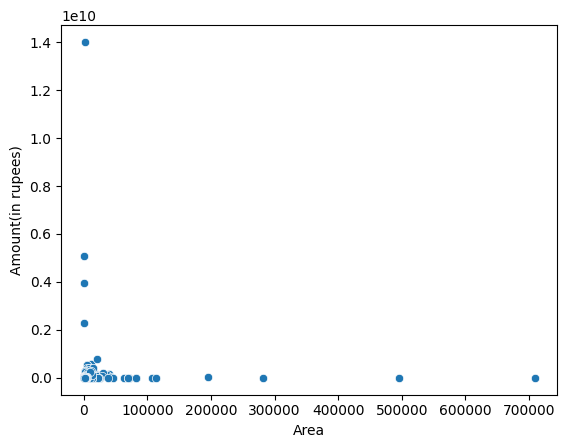

In [13]:
sns.scatterplot(data=house_changed, x='Area', y='Amount(in rupees)')

**FEATURE ENGINEERING**

In [14]:
X_2 = house_changed.loc[:,useful_features]
y_2 = X_2.pop('Amount(in rupees)')

mi_scores = make_mi_scores(X_2, y_2)
mi_scores

Area           2.379937
Floor Ratio    1.253865
location       0.969095
Bathroom       0.586346
facing         0.530493
Balcony        0.373431
Furnishing     0.252561
Ownership      0.219676
Transaction    0.185836
Name: MI Scores, dtype: float64

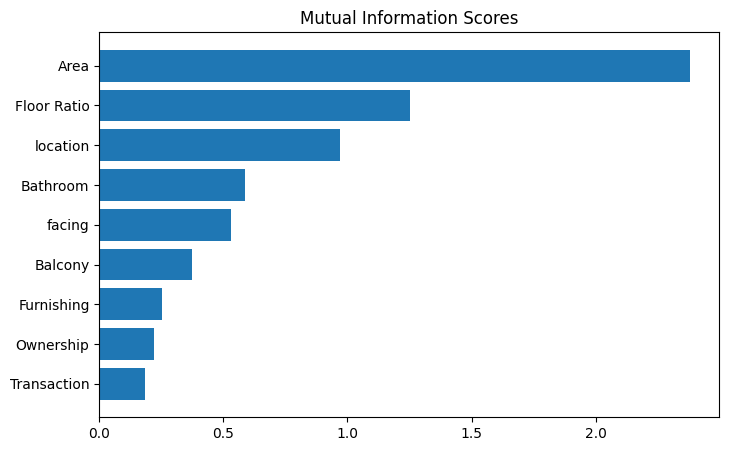

In [15]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

**USING DIFFERENT MODELS FOR LOWER MAE**

In [16]:
# Train test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, train_size=0.8, test_size=0.2, random_state=0)

In [17]:
# Initializing the model
linear_model = LinearRegression()

# Fit the model to the training data
linear_model.fit(X_train_2, y_train_2)

# Predicting on the test data
y_pred = linear_model.predict(X_test_2)

# linear_mse = mean_squared_error(y_test_2, y_pred)
# print(f"Mean Squared Error: {linear_mse}")

linear_mae = mean_absolute_error(y_test_2, y_pred)
print(f"MAE (Using LinearRegression): {linear_mae}")

# Coefficients of the model
# print(f"Coefficient (Slope): {linear_model.coef_[0]}")
# print(f"Intercept: {linear_model.intercept_}")

MAE (Using LinearRegression): 6045086.559596338


In [18]:
# Using XGBRegressor
XG_model = XGBRegressor(n_estimators=500, n_jobs=4, early_stopping_rounds=5, learning_rate=0.05)

XG_model.fit(X_train_2, y_train_2, eval_set=[(X_test_2, y_test_2)], verbose=False)

preds_2 = XG_model.predict(X_test_2)

XG_mae = mean_absolute_error(y_test_2, preds_2)

print("MAE (Using XGBRegressor):" , XG_mae)

MAE (Using XGBRegressor): 2806647.0223993603


In [19]:
# Using RandomForestRegressor
print("MAE (Using RandomForestRegressor): ",score_dataset(X_train_2, X_test_2, y_train_2, y_test_2))

MAE (Using RandomForestRegressor):  1321165.0068761138


In [20]:
# Creating and training the Decision Tree model
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train_2, y_train_2)

# Making predictions
y_pred = regressor.predict(X_test_2)

# Evaluating the model
mae = mean_absolute_error(y_test_2, y_pred)
print(f'MAE (Using DecisionTreeRegressor): {mae:.2f}')

MAE (Using DecisionTreeRegressor): 1523928.66
